In [1]:
!pip install librosa 

In [3]:
import os     # os: For interacting with the operating system (e.g., file paths)
import librosa     # librosa: For audio and music signal processing
import numpy as np        # numpy: For numerical operations
import pandas as pd            # pandas: For handling and analyzing datasets

# sklearn: For machine learning utilities like data splitting and preprocessing
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.preprocessing import LabelEncoder  # To convert string labels into numeric values

# TensorFlow Keras: For building and training deep learning models
from tensorflow.keras.utils import to_categorical  # To convert numeric labels into one-hot encoding
from tensorflow.keras.models import Sequential  # To define a sequential neural network model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D  # Essential layers for CNN

# matplotlib: For data visualization
import matplotlib.pyplot as plt  # To plot graphs and visualize results


In [5]:
# Define the path to the dataset folder
DATASET_PATH = r"C:\Users\User\Tess"  # Replace with your dataset directory


In [7]:
# Function to extract features from audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)  # Load audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # Extract MFCCs
    return np.mean(mfccs.T, axis=0)  # Return mean of MFCCs


In [9]:
# Function to load dataset and extract features
def load_data():
    features, labels = [], []
    for folder in os.listdir(DATASET_PATH):
        folder_path = os.path.join(DATASET_PATH, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(folder)  # Use folder name as label
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(features), np.array(labels)

# Load data
X, y = load_data()
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Data shape: (2800, 40)
Labels shape: (2800,)


In [13]:
# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (2240, 40)
Testing data shape: (560, 40)


In [15]:
# Reshape data for input into CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Reshaped training data: {X_train.shape}")
print(f"Reshaped testing data: {X_test.shape}")


Reshaped training data: (2240, 40, 1)
Reshaped testing data: (560, 40, 1)


In [17]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(40, 1, 1)),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


E:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 38, 1, 32)    │         128 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d               │ (None, 19, 1, 32)    │           0 │
│ (MaxPooling2D)              │                      │             │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dropout (Dropout)           │ (None, 19, 1, 32)    │           0 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ flatten (Flatten)           │ (None, 608)          │           0 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dense (Dense)               │ (None, 128)          │      77,952 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dropout_1 (Dropout)         │ (None, 128)          │           0 │
├─────────────────────────────┼──────────────────────┼─────────────┤
│ dense_1 (Dense)             │ (None, 14)           │       1,806 │
└─────────────────────────────┴──────────────────────┴─────────────┘

 Total params: 79,886 (312.05 KB)

 Trainable params: 79,886 (312.05 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1867 - loss: 13.7737 - val_accuracy: 0.7821 - val_loss: 0.6614
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5964 - loss: 1.3811 - val_accuracy: 0.9232 - val_loss: 0.3161
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7496 - loss: 0.7575 - val_accuracy: 0.9714 - val_loss: 0.1413
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8395 - loss: 0.5003 - val_accuracy: 0.9839 - val_loss: 0.0780
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8897 - loss: 0.3326 - val_accuracy: 0.9786 - val_loss: 0.0667
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9091 - loss: 0.2545 - val_accuracy: 0.9964 - val_loss: 0.0390
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9334 - loss: 0.2207 - val_accuracy: 0.9911 - val_loss: 0.0398
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9430 - loss: 0.1651 - val_accuracy: 0.9929 - val_los

In [21]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0079
Test Accuracy: 0.99


In [23]:
# Save the trained model
model.save("speech_emotion_recognition_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [29]:
# Load saved model for predictions
from tensorflow.keras.models import load_model

model = load_model("speech_emotion_recognition_model.h5")

# Predict emotion from a new audio file
def predict_emotion(file_path):
    feature = extract_features(file_path)
    feature = feature[np.newaxis, ..., np.newaxis]  # Reshape for model
    prediction = model.predict(feature)
    emotion = encoder.inverse_transform([np.argmax(prediction)])
    return emotion[0]

# Test with an example file
test_file = r"C:\Users\User\Tess\YAF_angry\YAF_came_angry.wav" 
predicted_emotion = predict_emotion(test_file)
print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Emotion: YAF_angry


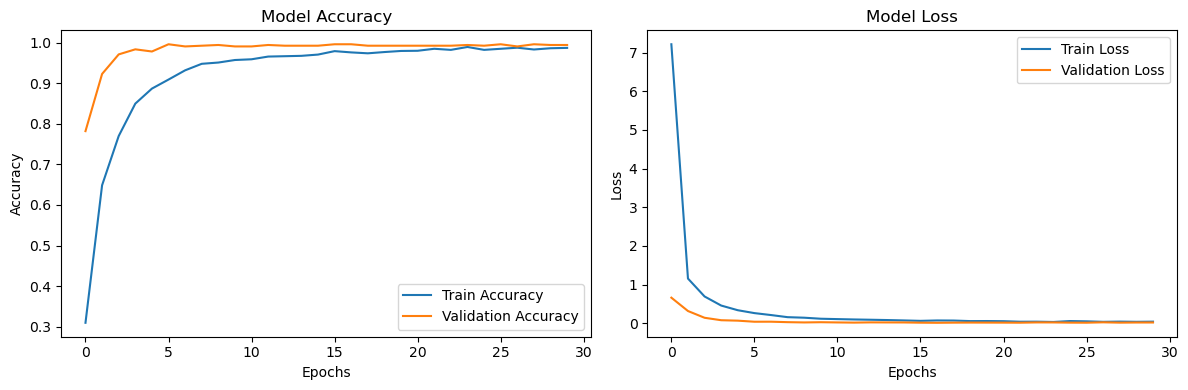

In [31]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
